<a href="https://colab.research.google.com/github/hamzaraouzi/Pytorch/blob/main/inceptionV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels,**kwrags):
    super(conv_block,self).__init__()
    self.relu = nn.ReLU()
    self.conv = nn.Conv2d(in_channels,out_channels,**kwrags)
    self.batchnorm = nn.BatchNorm2d(out_channels)

  def forward(self, x):
    return self.relu(self.batchnorm(self.conv(x)))

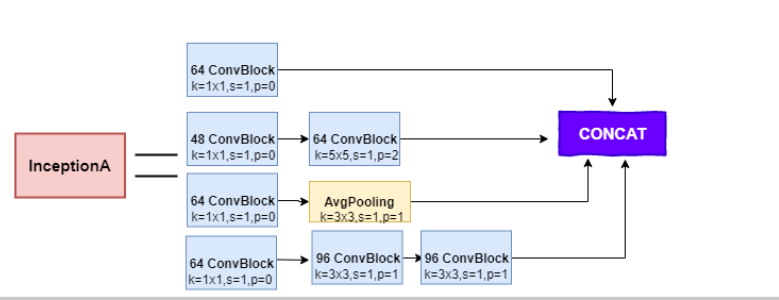

In [ ]:
class InceptionA(nn.Module):
    def __init__(self, in_channels,pool_features):
      super(InceptionA, self).__init__()

      self.branche1 = conv_block(in_channels, 64,kernel_size=(1,1))

      self.branche2 = nn.Sequential(
          conv_block(in_channels,48,kernel_size=(1,1)),
          conv_block(48,64,kernel_size=5,padding=2)
      )

      self.branche3 = nn.Sequential(
          conv_block(in_channels,64,kernel_size=(1,1)),
          conv_block(64,96,kernel_size=(3,3),padding=(1,1)),
          conv_block(96,96,kernel_size=(3,3),padding=(1,1))

      )
      
      self.branche4 = nn.Sequential(
          nn.AvgPool2d(kernel_size=(3,3),stride=(1,1),padding=(1,1)),
          conv_block(in_channels,pool_features,kernel_size=(1,1))
      )

    def forward(self, x):
     
      return torch.cat([
          self.branche1(x),self.branche2(x),self.branche3(x),self.branche4(x)
      ],1)


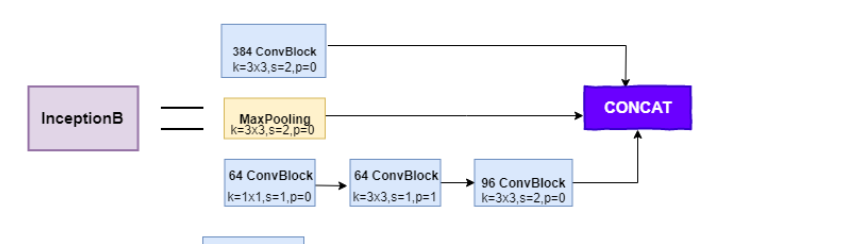

In [ ]:
class InceptionB(nn.Module):
  def __init__(self,in_channels):
    super(InceptionB,self).__init__()

    self.branche1 = conv_block(in_channels,384,kernel_size=3,stride=2)
    
    self.branche2 = nn.Sequential(
        conv_block(in_channels,64,kernel_size=1),
        conv_block(64,96,kernel_size=3,padding=1),
        conv_block(96,96,kernel_size=3,stride=2)
    )

    self.branche3 = nn.MaxPool2d(kernel_size=3,stride=2)

  def forward(self,x):
    b1_out = self.branche1(x)
    b2_out = self.branche2(x)
    b3_out = self.branche3(x)

    return torch.cat([b1_out,b2_out,b3_out],1)


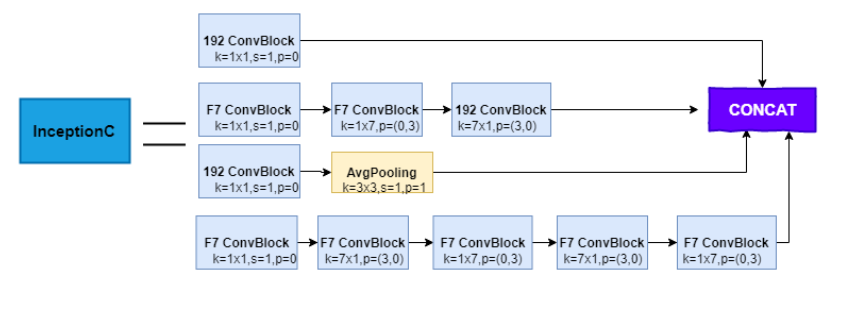

In [ ]:
class InceptionC(nn.Module):
  def __init__(self,in_channels,channels_7x7):
    super(InceptionC,self).__init__()

    self.branche1 = conv_block(in_channels,192,kernel_size=1)

    self.branche2 = nn.Sequential(
        conv_block(in_channels,channels_7x7,kernel_size=1),
        conv_block(channels_7x7,channels_7x7,kernel_size=(1,7),padding=(0,3)),
        conv_block(channels_7x7,192,kernel_size=(7,1),padding=(3,0)),
    )    
    self.branche3 = nn.Sequential(
        conv_block(in_channels,channels_7x7,kernel_size=1),
        conv_block(channels_7x7,channels_7x7,kernel_size=(7,1),padding=(3,0)),
        conv_block(channels_7x7,channels_7x7,kernel_size=(1,7),padding=(0,3)),
        conv_block(channels_7x7,channels_7x7,kernel_size=(7,1),padding=(3,0)),
        conv_block(channels_7x7,192,kernel_size=(1,7),padding=(0,3))
    )

    self.branche4 = nn.Sequential(
        nn.AvgPool2d(kernel_size=3,stride=1,padding=1),
        conv_block(in_channels,192,kernel_size=1)
    )

  def forward(self,x):
    b1_out = self.branche1(x)
    b2_out = self.branche2(x)
    b3_out = self.branche3(x)
    b4_out = self.branche4(x)

    return torch.cat([b1_out,b2_out,b3_out,b4_out],1)

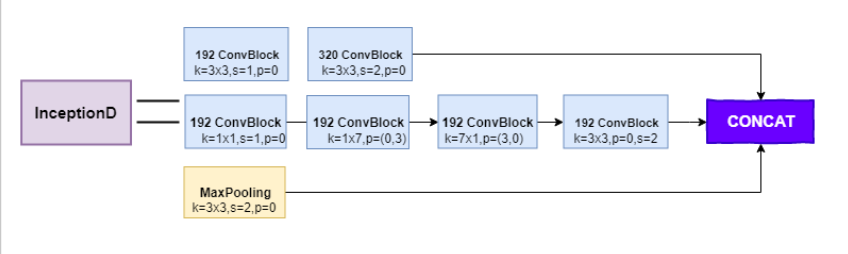

In [ ]:
class InceptionD(nn.Module):
  
  def __init__(self,in_channels):
    super(InceptionD,self).__init__()

    self.branche1 = nn.Sequential(
        conv_block(in_channels,192,kernel_size=1),
        conv_block(192,320,kernel_size=3,stride=2)
    )

    self.branche2 = nn.Sequential(
        conv_block(in_channels,192,kernel_size=1),
        conv_block(192,192,kernel_size=(1,7),padding=(0,3)),
        conv_block(192,192,kernel_size=(7,1),padding=(3,0)),
        conv_block(192,192,kernel_size=3, stride=2)
        )
    
    self.branche3 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=2)
    )

  def forward(self,x):
    b1_out = self.branche1(x)
    b2_out = self.branche2(x)
    b3_out = self.branche3(x)

    return torch.cat([b1_out,b2_out,b3_out],1)


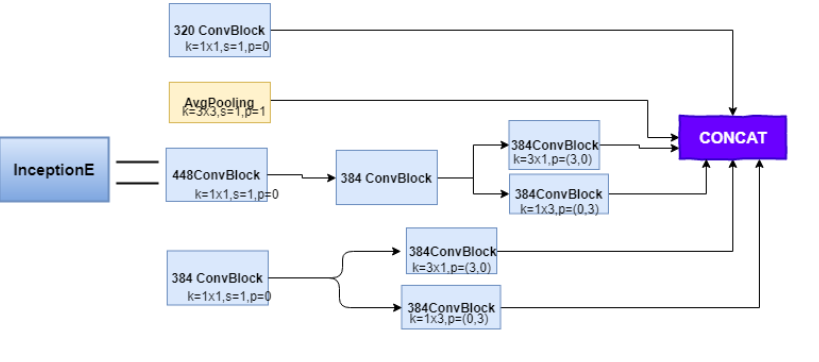

In [ ]:
class InceptionE(nn.Module):
  def __init__(self,in_channels):
    super(InceptionE,self).__init__()

    self.branch1x1 = conv_block(in_channels,320,kernel_size=1)

    self.branch3x3_1 = conv_block(in_channels,384,kernel_size=1)
    self.branch3x3_2a = conv_block(384,384,kernel_size=(1,3),padding=(0,1))
    self.branch3x3_2b = conv_block(384,384,kernel_size=(3,1),padding=(1,0))

    self.branch3x3dbl_1 = conv_block(in_channels,448,kernel_size=1)
    self.branch3x3dbl_2 = conv_block(448,384,kernel_size=3,padding=1)
    self.branch3x3dbl_3a = conv_block(384,384,kernel_size=(1,3),padding=(0,1))
    self.branch3x3dbl_3b = conv_block(384,384,kernel_size=(3,1),padding=(1,0))

    self.branch_pool = conv_block(in_channels,192,kernel_size=1)

  
  def forward(self,x):
      branch1x1 = self.branch1x1(x)

      branch3x3 = self.branch3x3_1(x)
      branch3x3 = [
            self.branch3x3_2a(branch3x3),
            self.branch3x3_2b(branch3x3),
        ]
      branch3x3 = torch.cat(branch3x3, 1)

      branch3x3dbl = self.branch3x3dbl_1(x)
      branch3x3dbl = self.branch3x3dbl_2(branch3x3dbl)
      branch3x3dbl = [
            self.branch3x3dbl_3a(branch3x3dbl),
            self.branch3x3dbl_3b(branch3x3dbl),
        ]
      branch3x3dbl = torch.cat(branch3x3dbl, 1)

      branch_pool = F.avg_pool2d(x, kernel_size=3, stride=1, padding=1)
      branch_pool = self.branch_pool(branch_pool)

      outputs = [branch1x1, branch3x3, branch3x3dbl, branch_pool]
      return torch.cat(outputs,1)





In [ ]:
class InceptionAux(nn.Module):

    def __init__(self,in_channels,num_classes):

        super(InceptionAux, self).__init__()

        self.conv0 = conv_block(in_channels, 128, kernel_size=1)
        self.conv1 = conv_block(128, 768, kernel_size=5)
        self.fc = nn.Linear(768, num_classes)

    def forward(self, x):
        # N x 768 x 17 x 17
        x = F.avg_pool2d(x, kernel_size=5, stride=3)
        # N x 768 x 5 x 5
        x = self.conv0(x)
        # N x 128 x 5 x 5
        x = self.conv1(x)
        # N x 768 x 1 x 1
        # Adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        # N x 768 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 768
        x = self.fc(x)
        # N x 1000
        return x


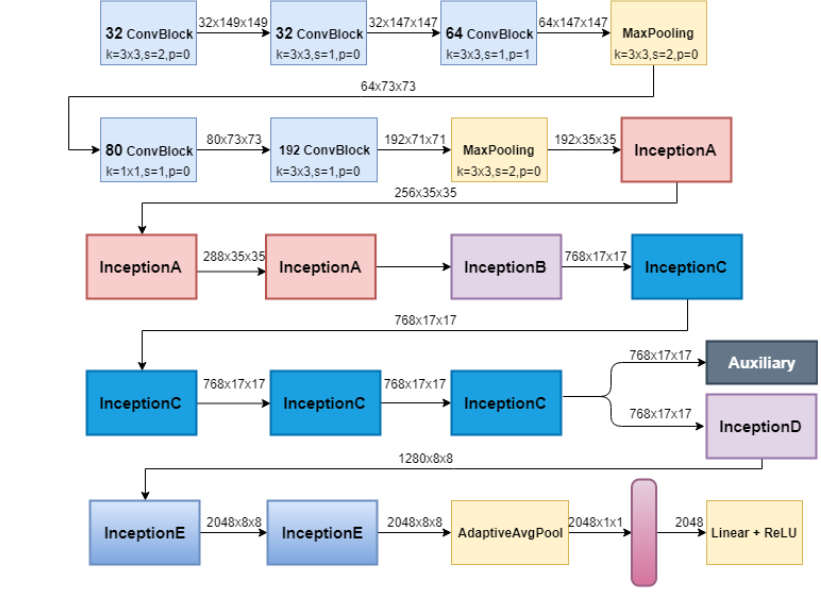

In [ ]:
class Inception3(nn.Module):
  def __init__(self,num_classes,aux_logits=True):
    super(Inception3,self).__init__()

    self.aux_logits = aux_logits
    self.num_classes=num_classes

    self.Conv2d_1a_3x3 = conv_block(3,32,kernel_size=3,stride=2)
    self.Conv2d_2a_3x3 = conv_block(32, 32, kernel_size=3)
    self.Conv2d_2b_3x3 = conv_block(32, 64, kernel_size=3, padding=1)
    
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
    
    self.Conv2d_3b_1x1 = conv_block(64, 80, kernel_size=1)
    self.Conv2d_4a_3x3 = conv_block(80, 192, kernel_size=3)
    
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
    
    self.Mixed_5b = InceptionA(192, pool_features=32)
    self.Mixed_5c = InceptionA(256, pool_features=64)
    self.Mixed_5d = InceptionA(288, pool_features=64)
    self.Mixed_6a = InceptionB(288)
    self.Mixed_6b = InceptionC(768, channels_7x7=128)
    self.Mixed_6c = InceptionC(768, channels_7x7=160)
    self.Mixed_6d = InceptionC(768, channels_7x7=160)
    self.Mixed_6e = InceptionC(768, channels_7x7=192)

    if aux_logits:
          self.AuxLogits = InceptionAux(768, num_classes)
    
    self.Mixed_7a = InceptionD(768)
    self.Mixed_7b = InceptionE(1280)
    self.Mixed_7c = InceptionE(2048)
    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout()
    self.fc = nn.Linear(2048, num_classes)

  def forward(self,x):
     # N x 3 x 299 x 299
        x = self.Conv2d_1a_3x3(x)
        # N x 32 x 149 x 149
        x = self.Conv2d_2a_3x3(x)
        # N x 32 x 147 x 147
        x = self.Conv2d_2b_3x3(x)
        # N x 64 x 147 x 147
        x = self.maxpool1(x)
        # N x 64 x 73 x 73
        x = self.Conv2d_3b_1x1(x)
        # N x 80 x 73 x 73
        x = self.Conv2d_4a_3x3(x)
        # N x 192 x 71 x 71
        x = self.maxpool2(x)
        # N x 192 x 35 x 35
        x = self.Mixed_5b(x)
        # N x 256 x 35 x 35
        x = self.Mixed_5c(x)
        # N x 288 x 35 x 35
        x = self.Mixed_5d(x)
        # N x 288 x 35 x 35
        x = self.Mixed_6a(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6b(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6c(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6d(x)
        # N x 768 x 17 x 17
        x = self.Mixed_6e(x)
        # N x 768 x 17 x 17
    
        
        if self.aux_logits:
          aux = self.AuxLogits(x)


        # N x 768 x 17 x 17
        x = self.Mixed_7a(x)
        # N x 1280 x 8 x 8
        x = self.Mixed_7b(x)
        # N x 2048 x 8 x 8
        x = self.Mixed_7c(x)
        # N x 2048 x 8 x 8
        # Adaptive average pooling
        x = self.avgpool(x)
        # N x 2048 x 1 x 1
        x = self.dropout(x)
        # N x 2048 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 2048
        x = self.fc(x)
        # N x 1000 (num_classes)
        if self.aux_logits:
          return x, aux
        
        return x

In [ ]:
x = torch.rand(3,3,299,299)
model = Inception3(aux_logits=True, num_classes=2)
y,_= model(x)
print(y.shape)

torch.Size([3, 2])


<h1>Date Preprocessing<h1>

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp  kaggle.json  ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 97% 526M/543M [00:02<00:00, 255MB/s]
100% 543M/543M [00:02<00:00, 225MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 75.5MB/s]
100% 271M/271M [00:01<00:00, 143MB/s]
100% 271M/271M [00:01<00:00, 148MB/s]


In [ ]:
from zipfile import ZipFile
file_name="test1.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


In [ ]:
from zipfile import ZipFile
file_name="train.zip"
with ZipFile(file_name,"r") as zip :
  zip.extractall()
  print('Done')

Done


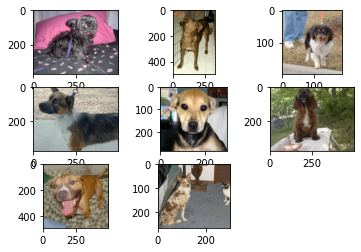

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
folder='train/'
for i in range(8):
  plt.subplot(330+1+i)
  filename=folder+'dog.'+str(i)+'.jpg'
  image=imread(filename)
  plt.imshow(image)
plt.show()

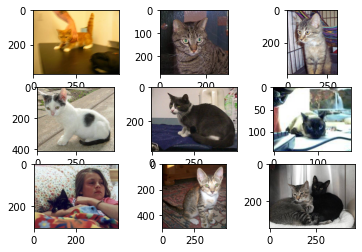

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
folder='train/'
for i in range(9):
  plt.subplot(330+1+i)
  filename=folder+'cat.'+str(i)+'.jpg'
  image=imread(filename)
  plt.imshow(image)
plt.show()

In [ ]:
# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)


In [ ]:
from torchvision import datasets, transforms
#Applying Transformation
train_transforms = transforms.Compose([
                                transforms.Resize((299,299)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

test_transforms = transforms.Compose([
                                      transforms.Resize((299,299)),
                                      transforms.ToTensor()])
train_data = datasets.ImageFolder(dataset_home  + '/train',  
                                    transform=train_transforms)                                       
test_data = datasets.ImageFolder(dataset_home + '/test', 
                                    transform=test_transforms)

#Data Loading
trainloader = torch.utils.data.DataLoader(train_data,shuffle=True,batch_size=32)
testloader = torch.utils.data.DataLoader(test_data,shuffle=True ,batch_size=32)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<h1>Train function</h1>

In [ ]:
accuracy_list = []

def train(epoch,model):
    model.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        # send to device
        data, target = data.to(device), target.to(device)


        optimizer.zero_grad()
        final_output, aux_2_out = model(data)
        
        loss1 = nn.CrossEntropyLoss()(final_output, target)
  
        loss3 = nn.CrossEntropyLoss()(aux_2_out, target)

        loss = loss1  + 0.3*loss3

        loss.backward()
        optimizer.step()
       
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


<h1>Test function</h1>

In [ ]:
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
   
    with torch.no_grad():
        for data, target in testloader:

            data, target = data.to(device), target.to(device)

            output = model(data)
            #sum up batch loss 
            loss = nn.CrossEntropyLoss()(output, target)
            test_loss += loss.item()
            _, predicted = output.max(1)

            correct += predicted.eq(target).sum().item()
        
        
        test_loss /= len(testloader.dataset)
        accuracy = 100.*correct/len(testloader.dataset)
        accuracy_list.append(accuracy)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct,len(testloader.dataset),
            accuracy
        ))

    return accuracy,test_loss

<h1>Training Loop</h1>

In [ ]:
model.to(device)

PATH ='model.pt'

optimizer = optim.Adam(model.parameters(),lr=0.01)

prev_test_accuracy =-1
for epoch in range(0,100):
  
    model.aux_logits = True
    train(epoch,model)
    model.aux_logits = False
    test_accuracy,test_loss = test(model)

    if test_accuracy >prev_test_accuracy:
        torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': test_loss,
                }, PATH)
        print("weights from epoch {} has been saved ".format(epoch))
        prev_test_accuracy = test_accuracy

<h1>Loading the best weights</h1>

In [ ]:
loaded_model = Inception3(aux_logits=True, num_classes=2)


optimizer = optim.Adam(model.parameters(),lr=0.01)

checkpoint = torch.load(PATH)
loaded_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

loaded_model.to(device)
loaded_model.eval()
loaded_model.aux_logits= False
test_accuracy,test_loss= test(loaded_model)


Test set: Average loss: 0.0031, Accuracy: 6070/6303 (96%)

